# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from maddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import random
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.09000000171363354


### 4. Train the MADDPG Agent
Now it's your turn to train your own agent to solve the environment! When training the environment, set train_mode=True, so that the line for resetting the environment looks like the following:

env_info = env.reset(train_mode=True)[brain_name]

In [6]:
def maddpg(n_episodes=5000, max_t=1000,  maxlen=100, solved_score_limit=0.5, train_mode=True):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG) 
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode
        maxlen(int): the window size to take the average scores 
        solved_score (float)  : minimun average score over maxlen consecutive episodes, and over all agents
    """
    scores_window = deque(maxlen = maxlen)  # mean score list over maxlen episodes
    scores_all = []  # all scores for for agent and each episode
    max_scores_agents = [] # the max score of the two agents in each episode
    mean_score_episodes = [] # the max score of the two agents averaged over continuous episodes 
   
    solved = 0 
    solved_episode = 0 
    solved_score = 0
    best_episode = 0
    best_score = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode = train_mode)[brain_name] # reset the environment
        states = env_info.vector_observations     # get the current state for each agent
        scores = np.zeros(num_agents)            
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)  # select the action with adding noise, for each agent
            env_info = env.step(actions)[brain_name]     # send the action to the environment
            next_states = env_info.vector_observations   # get the next state for each agent
            rewards = env_info.rewards                   # get the reward for each agent
            dones = env_info.local_done                  # see if episode has finished
            #print(states)        
            #print(actions)       
            #print(next_states) 
            #print(dones)
            #print(rewards)       
                           
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards            
            if np.any(dones):
                break 
             
        scores_all.append(scores)     
        max_scores_agents.append(np.max(scores))
        scores_window.append(np.max(scores))   
        average_score = np.mean(scores_window)  
        mean_score_episodes.append(average_score)
        
        print('\rEpisode {}\t Max Score: {:.2f} \t Average Score: {:.2f}'.format(i_episode, np.max(scores), average_score))
        if average_score>=solved_score_limit and train_mode and solved == 0:
            print('\n Target Score Reached in {:d} episodes!\t Average Score: {:.2f}'.format(i_episode,average_score))
            torch.save(agent.return_actors()[0].state_dict(), 'solved_checkpoint_actor1.pth')
            torch.save(agent.return_actors()[1].state_dict(), 'solved_checkpoint_actor2.pth')
            torch.save(agent.return_critic().state_dict(), 'solved_checkpoint_critic.pth')
            solved = 1
            solved_episode = i_episode
            solved_score = average_score
            torch.save({
            'solved_episode': solved_episode,
            'solved_score': solved_score,
            'scores_all': scores_all,
            'max_scores_agents': max_scores_agents,
            'mean_score_episodes': mean_score_episodes,
            }, 'traning_solved_scores.pt')        
        
        if average_score > best_score and train_mode:
            print('\nBest Score Reached in {:d} episodes!\t Best Average Score: {:.2f}'.format(i_episode,average_score))
            torch.save(agent.return_actors()[0].state_dict(), 'bestscore_checkpoint_actor1.pth')
            torch.save(agent.return_actors()[1].state_dict(), 'bestscore_checkpoint_actor2.pth')
            torch.save(agent.return_critic().state_dict(), 'bestscore_checkpoint_critic.pth')
            best_episode = i_episode
            best_score = average_score
            torch.save({
            'best_episode': best_episode,
            'best_score': best_score,
            'scores_all': scores_all,
            'max_scores_agents': max_scores_agents,
            'mean_score_episodes': mean_score_episodes,
            }, 'training_bestscores.pt')
    
        torch.save({
            'i_episode': i_episode,
            'solved_episode': solved_episode,
            'solved_score': solved_score,
            'best_episode': best_episode,
            'best_score': best_score,
            'scores_all': scores_all,
            'max_scores_agents': max_scores_agents,
            'mean_score_episodes': mean_score_episodes,
            }, 'training_all_scores.pt')
    print('\n\nTraining Done...')
    if solved == 1:
        print('\nTarget Score Reached in {:d} episodes,\t Average Score: {:.2f}'.format(solved_episode,solved_score))
    print('\nBest Score Reached in {:d} episodes,\t Best Average Score: {:.2f}'.format(best_episode,best_score))
    return scores_all,  max_scores_agents, mean_score_episodes


### 5. Plot the Training Scores

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=9999, num_agents=num_agents)
scores,  max_scores_agents, mean_score_episodes = maddpg()

Episode 1	 Max Score: 0.00 	 Average Score: 0.00
Episode 2	 Max Score: 0.00 	 Average Score: 0.00
Episode 3	 Max Score: 0.00 	 Average Score: 0.00
Episode 4	 Max Score: 0.00 	 Average Score: 0.00
Episode 5	 Max Score: 0.00 	 Average Score: 0.00
Episode 6	 Max Score: 0.00 	 Average Score: 0.00
Episode 7	 Max Score: 0.00 	 Average Score: 0.00
Episode 8	 Max Score: 0.00 	 Average Score: 0.00
Episode 9	 Max Score: 0.00 	 Average Score: 0.00
Episode 10	 Max Score: 0.00 	 Average Score: 0.00
Episode 11	 Max Score: 0.00 	 Average Score: 0.00
Episode 12	 Max Score: 0.00 	 Average Score: 0.00
Episode 13	 Max Score: 0.00 	 Average Score: 0.00
Episode 14	 Max Score: 0.00 	 Average Score: 0.00
Episode 15	 Max Score: 0.00 	 Average Score: 0.00
Episode 16	 Max Score: 0.00 	 Average Score: 0.00
Episode 17	 Max Score: 0.00 	 Average Score: 0.00
Episode 18	 Max Score: 0.00 	 Average Score: 0.00
Episode 19	 Max Score: 0.00 	 Average Score: 0.00
Episode 20	 Max Score: 0.00 	 Average Score: 0.00
Episode 2

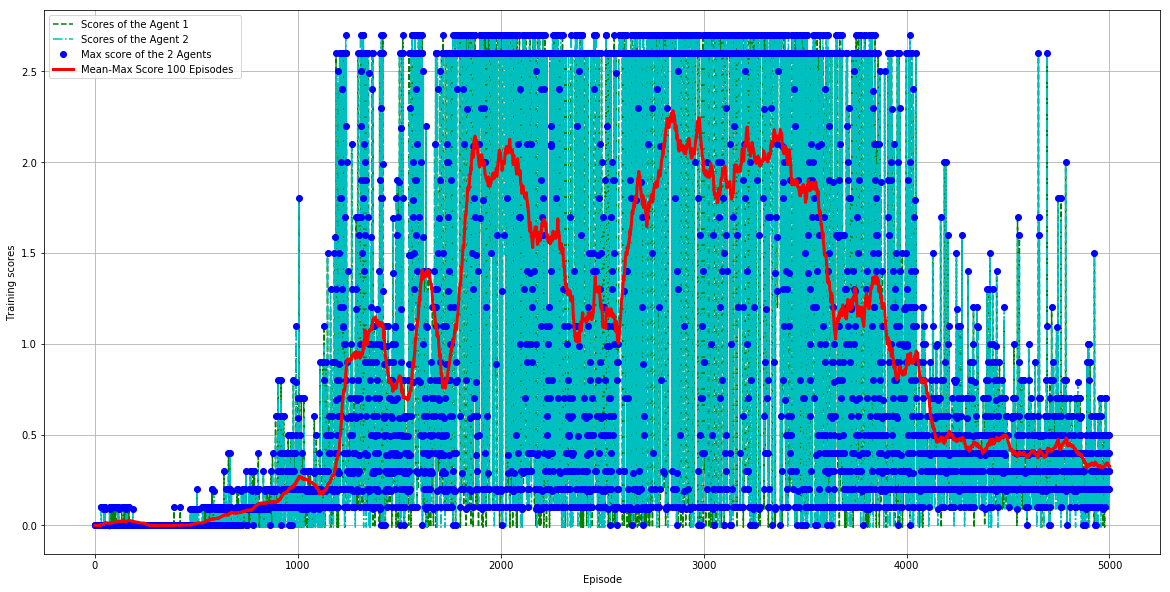

In [8]:
checkpoint = torch.load('training_all_scores.pt')
scores = checkpoint['scores_all']
max_scores_agents = checkpoint['max_scores_agents']
mean_score_episodes =  checkpoint['mean_score_episodes']
plt.figure(figsize=(20,10))
scores=np.array(scores)
m,n=scores.shape
plt.plot(np.arange(1, len(scores)+1), scores[:,0], 'g--')  
plt.plot(np.arange(1, len(scores)+1), scores[:,1], 'c-.')    
plt.plot(np.arange(1, len(scores)+1), max_scores_agents, 'bo')
plt.plot(np.arange(1, len(scores)+1), mean_score_episodes,'r', linewidth=3.0)
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Training scores')
plt.legend(('Scores of the Agent 1', 'Scores of the Agent 2','Max score of the 2 Agents', 'Mean-Max Score 100 Episodes '), loc='upper left')
plt.show()

### 6. Watch a Smart Agent to Play

In [9]:
# solved check point
agent.actors_local[0].load_state_dict(torch.load('solved_checkpoint_actor1.pth'))
agent.actors_local[1].load_state_dict(torch.load('solved_checkpoint_actor2.pth'))
agent.critic_local.load_state_dict(torch.load('solved_checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
play_episodes  =  10
for i in range(1, play_episodes+1):
    while True:
        actions = agent.act(states)                        # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.5900000091642141
Score (max over agents) from episode 2: 1.6800000257790089
Score (max over agents) from episode 3: 1.7700000293552876
Score (max over agents) from episode 4: 2.070000033825636
Score (max over agents) from episode 5: 2.560000041499734
Score (max over agents) from episode 6: 3.3500000536441803
Score (max over agents) from episode 7: 3.740000059828162
Score (max over agents) from episode 8: 4.930000077933073
Score (max over agents) from episode 9: 5.520000087097287
Score (max over agents) from episode 10: 6.110000096261501


In [10]:
# best score checkpoint
agent.actors_local[0].load_state_dict(torch.load('bestscore_checkpoint_actor1.pth'))
agent.actors_local[1].load_state_dict(torch.load('bestscore_checkpoint_actor2.pth'))
agent.critic_local.load_state_dict(torch.load('bestscore_checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
play_episodes  =  10
for i in range(1, play_episodes+1):
    while True:
        actions = agent.act(states)                        # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 5.300000078976154
Score (max over agents) from episode 3: 7.900000117719173
Score (max over agents) from episode 4: 10.500000156462193
Score (max over agents) from episode 5: 13.200000196695328


UnityActionException: The episode is completed. Reset the environment with 'reset()'

When finished, you can close the environment.

In [ ]:
env.close()